## Start code

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski

import skimage.io
import skimage.transform

import scipy.fftpack as spfft 

In [196]:
img_path = 'SonOfMan.png'
#img_path  = "beauty.jpeg"
# read image
img_og = ski.io.imread(img_path)

# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og)

#fig, ax = plt.subplots(1, 2, figsize=(20,10))
#ax[0].imshow(img_og, cmap = 'gray')
#ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# resize image 
img = ski.transform.rescale( img_og, 0.18, anti_aliasing=False)
print("Rescaled size: ", img.shape)

#ax[1].imshow(img, cmap='gray')
#ax[1].set_title("Rescaled image")

Original size:  (292, 228)
Rescaled size:  (53, 41)


<ipython-input-196-99321ef27d1e>:7: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_og = ski.color.rgb2gray(img_og)


## Helper functions

In [249]:
# constrauct forward and inverse DCT matrices 

# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: D DCT matrix mapping image.flatten() to 
  #         DCT(image).flatten()

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D

# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: iD iDCT matrix mapping DCT(image).flatten() to 
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D


# function that set the coef below threshold to 0
def thresholding(dctf,percent):
    thre = np.percentile(dctf,100 - percent)
    result = np.zeros(dctf.shape)
    for i in range(len(dctf)):
        if dctf[i] >= thre:
            result[i] = dctf[i]
    return result

# function that recovers the image using L1 norm
def one_round(r):
    N = Nx * Ny
    M = int(np.floor(N*r))
    I = np.identity(N)
    I = np.random.permutation(I)
    B = I[0:M,:]
    y = np.dot(B,vimg).reshape(-1,1)
    A = np.dot(B,D_inv)
    
    vb = cvx.Variable((N,1)) #vb for vector beta
    objective_dct = cvx.Minimize( cvx.norm(vb, 1) )
    constraints_dct = [A@vb == y] # equality constraints at the observation points

    problem_dct = cvx.Problem(objective_dct, constraints_dct)
    result = problem_dct.solve(verbose=True,solver = 'CVXOPT',max_iter = 1000,reltol = 1e-2,featol = 1e-2)
    plt.imshow(np.dot(D_inv, vb.value).reshape(Nx, Ny), cmap='gray');
    print("r = ",r)

## Image Compression

### (a)

In [197]:
Nx = img.shape[0] # number of columns
Ny = img.shape[1] # number of rows

D = construct_DCT_Mat(Nx,Ny)
D_inv = construct_iDCT_Mat(Nx,Ny)

### (b)

Number of zero coefficients:  1073


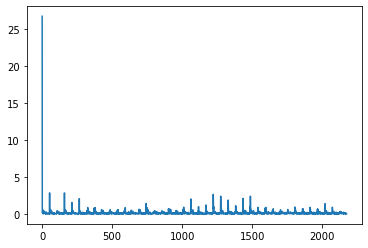

In [199]:
vimg = img.flatten().reshape(-1,1) # vec(F)

dctf = np.dot(D, vimg)
plt.plot(np.arange(len(dctf)), np.abs(dctf))
print("Number of zero coefficients: ",np.sum(dctf <= 10**-6))

<b>As we could see from the plot and calculation above, nearly half of the coefficients are zero and there is only one large coefficient (the first one).</b>

### (c) 

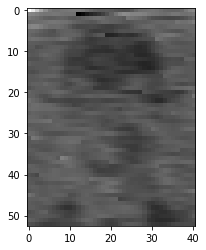

In [200]:
plt.imshow(np.dot(D_inv, thresholding(dctf,5)).reshape(Nx, Ny), cmap='gray');

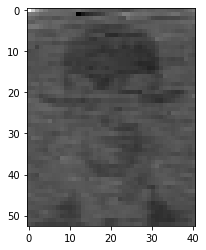

In [201]:
plt.imshow(np.dot(D_inv, thresholding(dctf,10)).reshape(Nx, Ny), cmap='gray');

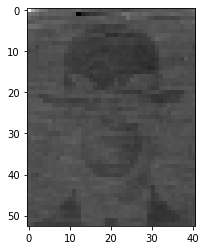

In [259]:
plt.imshow(np.dot(D_inv, thresholding(dctf,20)).reshape(Nx, Ny), cmap='gray');

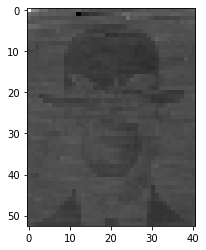

In [260]:
plt.imshow(np.dot(D_inv, thresholding(dctf,40)).reshape(Nx, Ny), cmap='gray');

## Compressed Image Recovery

### r = 0.2

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:11:02 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:11:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:11:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:11:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:11:02 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:11:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

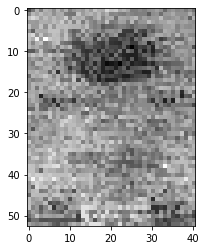

In [248]:
# first round
one_round(0.2)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:16:37 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:16:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:16:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:16:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:16:37 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:16:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

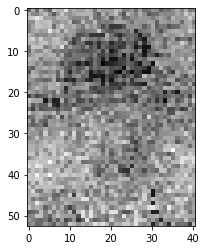

In [250]:
# second round
one_round(0.2)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:17:20 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:17:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:17:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:17:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:17:20 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:17:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

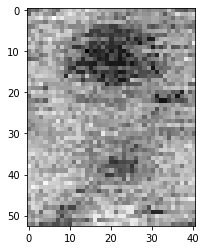

In [251]:
# third round
one_round(0.2)

### r = 0.4

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:18:07 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:18:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:18:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:18:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:18:07 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:18:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

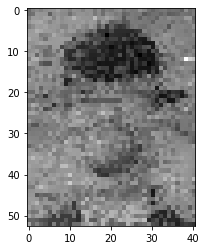

In [252]:
# first round
one_round(0.4)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:19:06 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:19:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:19:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:19:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:19:06 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:19:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

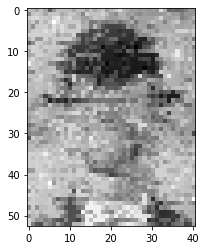

In [253]:
# second round
one_round(0.4)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:19:59 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:19:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:19:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:19:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:19:59 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:19:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

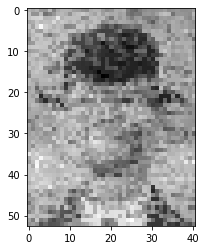

In [254]:
# third round
one_round(0.4)

### r = 0.6

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:20:55 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:20:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:20:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:20:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:20:55 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:20:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

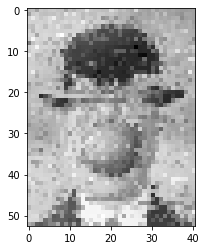

In [255]:
# first round
one_round(0.6)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:24:51 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:24:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:24:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:24:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:24:51 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:24:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

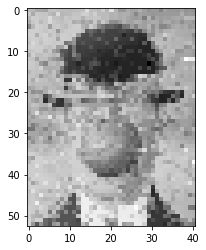

In [257]:
# second round
one_round(0.6)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 09:26:04 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 09:26:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 09:26:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 09:26:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 09:26:04 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 09:26:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

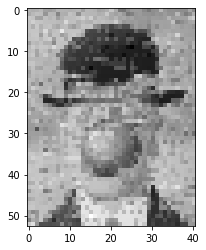

In [258]:
# third round
one_round(0.6)

## Mysterious Image

In [293]:
data = np.load('UnknownImage.npz')
B = data[data.files[0]]
y = data[data.files[1]].reshape(-1,1)

D2 = construct_DCT_Mat(50,50)
D_inv2 = construct_iDCT_Mat(50,50)

In [294]:
A = np.dot(B,D_in
problem_dct = cvxv2)
vb = cvx.Variable((2500,1)) #vb for vector beta
objective_dct = cvx.Minimize( cvx.norm(vb, 1) )
constraints_dct = [A@vb == y] # equality constraints at the observation points
.Problem(objective_dct, constraints_dct)
result = problem_dct.solve(verbose=True,solver = 'CVXOPT',max_iter = 1000,reltol = 1e-2,featol = 1e-2)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 10 10:40:57 PM: Your problem has 2500 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 10 10:40:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 10:40:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 10:40:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 10:40:57 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 10 10:40:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

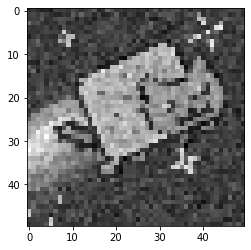

In [295]:
plt.imshow(np.dot(D_inv2, vb.value).reshape(50, 50), cmap='gray');

**It's a Nyan cat**